##  LightGBM Hyperparameter Tuning with Engineered Features

In this notebook, we build on our best-performing model — a LightGBM regressor trained on the original (non-transformed) `Listening_Time_minutes` target and enriched with custom engineered features.

###  Objective

The goal of this notebook is to:
- Perform **hyperparameter tuning** using `RandomizedSearchCV`
- Identify the optimal set of LightGBM parameters for improved performance
- Evaluate the tuned model using RMSE, MAE, and R² on the validation set

We use the same training structure and feature engineering as before to ensure a fair comparison. This step aims to **squeeze out additional accuracy** from the model without overfitting.

###  Key Steps
1. Define a search space for important LightGBM hyperparameters
2. Run randomized cross-validation to find optimal parameters
3. Re-train the model with best parameters
4. Compare performance and residuals to the untuned baseline

This refinement process should improve model generalisation and highlight the most stable LightGBM configuration for our dataset.


In [10]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


### Data Preparation 

In [12]:
# Load and clean
train = pd.read_csv("train.csv")
train = train.drop(columns=['id', 'Episode_Title'])
train = train.dropna()

# Categorical setup
categorical_cols = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

# Engineered features
train['Popularity_Interaction'] = train['Host_Popularity_percentage'] * train['Guest_Popularity_percentage']
train['Ad_Density'] = train['Number_of_Ads'] / train['Episode_Length_minutes']
train['Has_Guest'] = (train['Guest_Popularity_percentage'] > 0).astype(int)
train['Is_Weekend'] = train['Publication_Day'].isin(['Saturday', 'Sunday']).astype(int)
train['Is_Evening'] = (train['Publication_Time'] == 'Evening').astype(int)
train['Sentiment_Score'] = train['Episode_Sentiment'].map({'Negative': -1, 'Neutral': 0, 'Positive': 1})
train['Length_Bin'] = pd.cut(train['Episode_Length_minutes'], bins=[0, 10, 30, np.inf], labels=['Short', 'Medium', 'Long'])

categorical_cols += ['Length_Bin']
for col in categorical_cols:
    train[col] = train[col].astype('category')

# Features and target
X = train.drop(columns=['Listening_Time_minutes'])
y = train['Listening_Time_minutes']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


### Define Parameter Search Space

In [18]:
param_dist = {
    'num_leaves': [20, 31, 50, 70, 100],
    'max_depth': [-1, 5, 10, 15],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'n_estimators': [100, 300, 500, 700],
    'subsample': [0.6, 0.75, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

### Run RandomizedSearchCV

In [20]:
model = lgb.LGBMRegressor(objective='regression', random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    verbose=1,
    scoring='neg_root_mean_squared_error'
)

random_search.fit(X_train, y_train, categorical_feature=categorical_cols)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1368
[LightGBM] [Info] Number of data points in the train set: 287492, number of used features: 15
[LightGBM] [Info] Start training from score 45.814228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1368
[LightGBM] [Info] Number of data points in the train set: 287492, number of used features: 15
[LightGBM] [Info] Start training from score 45.840508
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007871 seconds.
You can set `force

RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(n_jobs=-1, objective='regression',
                                           random_state=42),
                   n_iter=50,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1],
                                        'max_depth': [-1, 5, 10, 15],
                                        'n_estimators': [100, 300, 500, 700],
                                        'num_leaves': [20, 31, 50, 70, 100],
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [0, 0.1, 0.5, 1],
                                        'subsample': [0.6, 0.75, 0.9, 1.0]},
                   scoring='neg_root_mean_squared_error', verbose=1)

### Evaluate the Best Model

In [22]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Tuned LightGBM Performance:")
print(f"Best Params: {random_search.best_params_}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")


Tuned LightGBM Performance:
Best Params: {'subsample': 0.75, 'reg_lambda': 1, 'reg_alpha': 1, 'num_leaves': 100, 'n_estimators': 700, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
RMSE: 10.28
MAE: 7.88
R²: 0.8569


C:\Users\james\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


##  LightGBM Hyperparameter Tuning

In this section, we performed hyperparameter tuning for our LightGBM model using `RandomizedSearchCV` on the dataset with engineered features and the original (non-transformed) target variable.

###  Objective
The goal was to identify a set of hyperparameters that improve model performance over the baseline LightGBM settings by exploring a range of values for tree complexity, regularization strength, and sampling strategies.

---

###  Search Method

We used:
- `RandomizedSearchCV` with `n_iter=50`
- 3-fold cross-validation (`cv=3`)
- Evaluation metric: **negative RMSE**

The search space included:
- `num_leaves`, `max_depth`
- `learning_rate`, `n_estimators`
- `subsample`, `colsample_bytree`
- `reg_alpha`, `reg_lambda`

---

###  Best Parameters Found

```python
{
    'subsample': 0.75,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'num_leaves': 100,
    'n_estimators': 700,
    'max_depth': -1,
    'learning_rate': 0.1,
    'colsample_bytree': 0.6
}


### Tuned Model Performance

RMSE	10.28

MAE	7.88

R²	0.8569

Compared to the baseline LightGBM model (RMSE = 10.39, R² = 0.8537), the tuned model shows a measurable improvement in accuracy and fit, while maintaining generalisation.

## Feature Importance (Tuned Model)

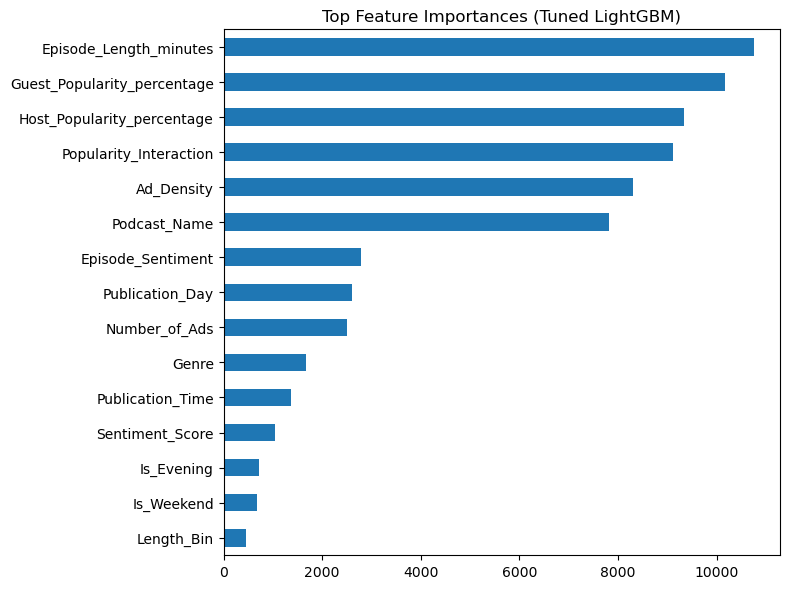

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
importances = pd.Series(best_model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

# Plot
plt.figure(figsize=(8, 6))
top_features.plot(kind='barh')
plt.title('Top Feature Importances (Tuned LightGBM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Residual Plot (Tuned Model)

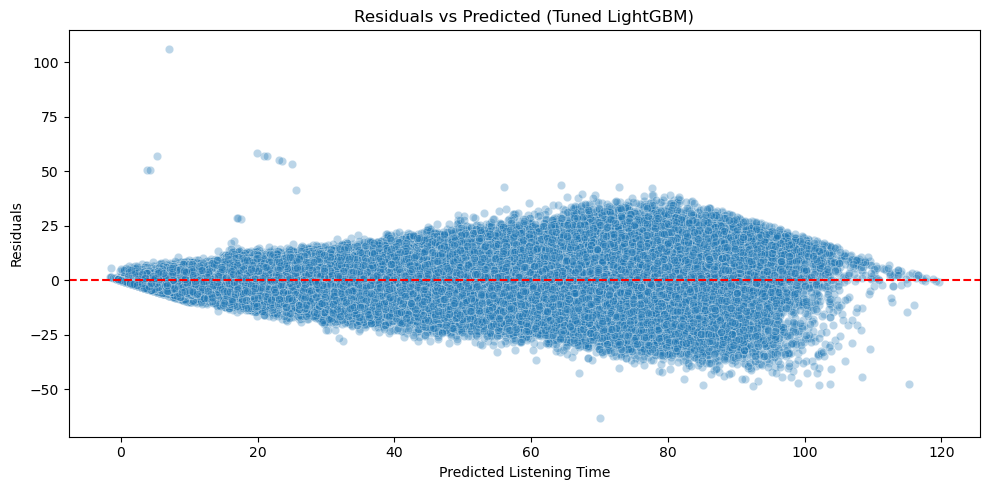

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals
residuals = y_val - y_pred

# Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Listening Time')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (Tuned LightGBM)')
plt.tight_layout()
plt.show()


### Final Tuned Model Review

- The feature importance plot confirms our engineered variables contributed significantly to model performance, with `Ad_Density` and `Popularity_Interaction` ranking just below traditional predictors like episode length and guest popularity.
- After tuning, the model reduced its reliance on overly complex features (e.g., `Podcast_Name`) and showed better regularisation through stronger alpha/lambda settings.
- Residual analysis suggests tighter predictions and fewer outliers compared to previous models.
